# Required packages

In [50]:
import requests
import json
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np

In [3]:
def get_kline_data():
    '''
    This function block retrieve historical
    Kline data for BTCINR with interval of 1 day
    '''
    try:
        # Crypto currency pair of interest
        pair = "BTCINR"
        interval = "1m"

        # Prepare the request body (JSON)
        params = {
            'pair': pair,
            'interval': interval,
            'limit': 5000 
        }

        # Headers for the POST request (no API key or signature required)
        headers = {
            'Content-Type': 'application/json'
        }

        # Construct the full URL for the Kline endpoint
        kline_url = "https://api.pi42.com/v1/market/klines"

        # Send the POST request to get Kline data
        response = requests.post(kline_url, json=params, headers=headers)
        response.raise_for_status()  # Raises an error for 4xx/5xx responses

        # Parse the JSON response data and save it to a variable
        response_data = response.json()

        # Save the data into a variable
        kline_data = response_data

        return kline_data

    except ValueError:
        print("Please enter valid inputs for pair, interval.")
    except requests.exceptions.HTTPError as err:
        print(f"Error: {err.response.text if err.response else err}")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")

# Fetching the data and keeping in Panda's dataframe

In [4]:
data = get_kline_data()
df = pd.DataFrame(data)

# Data preprocessing

#### The data type of every column is not correct. Making proper changes below

In [5]:
df.dtypes

startTime    object
open         object
high         object
low          object
close        object
endTime      object
volume       object
dtype: object

In [6]:
df['startTime'] = pd.to_datetime(df['startTime'], unit='ms')
df['open'] = pd.to_numeric(df['open'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['close'] = pd.to_numeric(df['close'])
df['volume'] = pd.to_numeric(df['volume'])
df['endTime'] = pd.to_datetime(df['endTime'], unit='ms')

C:\Users\goura\AppData\Local\Temp\ipykernel_2492\1418480079.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['startTime'] = pd.to_datetime(df['startTime'], unit='ms')
C:\Users\goura\AppData\Local\Temp\ipykernel_2492\1418480079.py:7: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['endTime'] = pd.to_datetime(df['endTime'], unit='ms')


In [7]:
df.dtypes

startTime    datetime64[ns]
open                  int64
high                  int64
low                   int64
close                 int64
endTime      datetime64[ns]
volume              float64
dtype: object

#### Now, the data are in correct format

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   startTime  1500 non-null   datetime64[ns]
 1   open       1500 non-null   int64         
 2   high       1500 non-null   int64         
 3   low        1500 non-null   int64         
 4   close      1500 non-null   int64         
 5   endTime    1500 non-null   datetime64[ns]
 6   volume     1500 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4)
memory usage: 82.2 KB


In [9]:
df.head()

,startTime,open,high,low,close,endTime,volume
0,2024-10-06 17:26:00,5469150,5469211,5468452,5468452,2024-10-06 17:26:59.999,0.065
1,2024-10-06 17:27:00,5468452,5468452,5466542,5466542,2024-10-06 17:27:59.999,2.854
2,2024-10-06 17:28:00,5466368,5467467,5465714,5465714,2024-10-06 17:28:59.999,0.289
3,2024-10-06 17:29:00,5465356,5465356,5465356,5465356,2024-10-06 17:29:59.999,0.049
4,2024-10-06 17:30:00,5466115,5467414,5465147,5465147,2024-10-06 17:30:59.999,1.842


In [10]:
df.tail()

,startTime,open,high,low,close,endTime,volume
1495,2024-10-07 18:21:00,5511710,5518984,5510727,5517104,2024-10-07 18:21:59.999,4.994
1496,2024-10-07 18:22:00,5518705,5520115,5516426,5520115,2024-10-07 18:22:59.999,2.919
1497,2024-10-07 18:23:00,5519950,5520289,5516582,5517801,2024-10-07 18:23:59.999,1.333
1498,2024-10-07 18:24:00,5517801,5518375,5512905,5512905,2024-10-07 18:24:59.999,2.569
1499,2024-10-07 18:25:00,5512905,5517132,5512705,5517132,2024-10-07 18:25:59.999,3.217


#### There are total 341 data fetched. The start date is 1st Nov 2023 and ends in 6th Oct 2024 (The day of execution).

In [11]:
df.isna().sum()

startTime    0
open         0
high         0
low          0
close        0
endTime      0
volume       0
dtype: int64

#### There are no NaN values

# Descriptive statistics over numerical columns

In [12]:
df[["open", "high", "low", "close"]].describe()

,open,high,low,close
count,1.500000e+03,1.500000e+03,1.500000e+03,1.500000e+03
mean,5.512622e+06,5.514695e+06,5.510730e+06,5.512666e+06
std,4.052152e+04,4.092550e+04,4.018815e+04,4.048195e+04
min,5.429343e+06,5.430642e+06,5.429273e+06,5.429709e+06
25%,5.474360e+06,5.476361e+06,5.472683e+06,5.474563e+06
50%,5.524923e+06,5.526846e+06,5.522704e+06,5.524975e+06
75%,5.545894e+06,5.547403e+06,5.544071e+06,5.546045e+06
max,5.612925e+06,5.620189e+06,5.611303e+06,5.612567e+06


# Exploratory data analysis

C:\Users\goura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


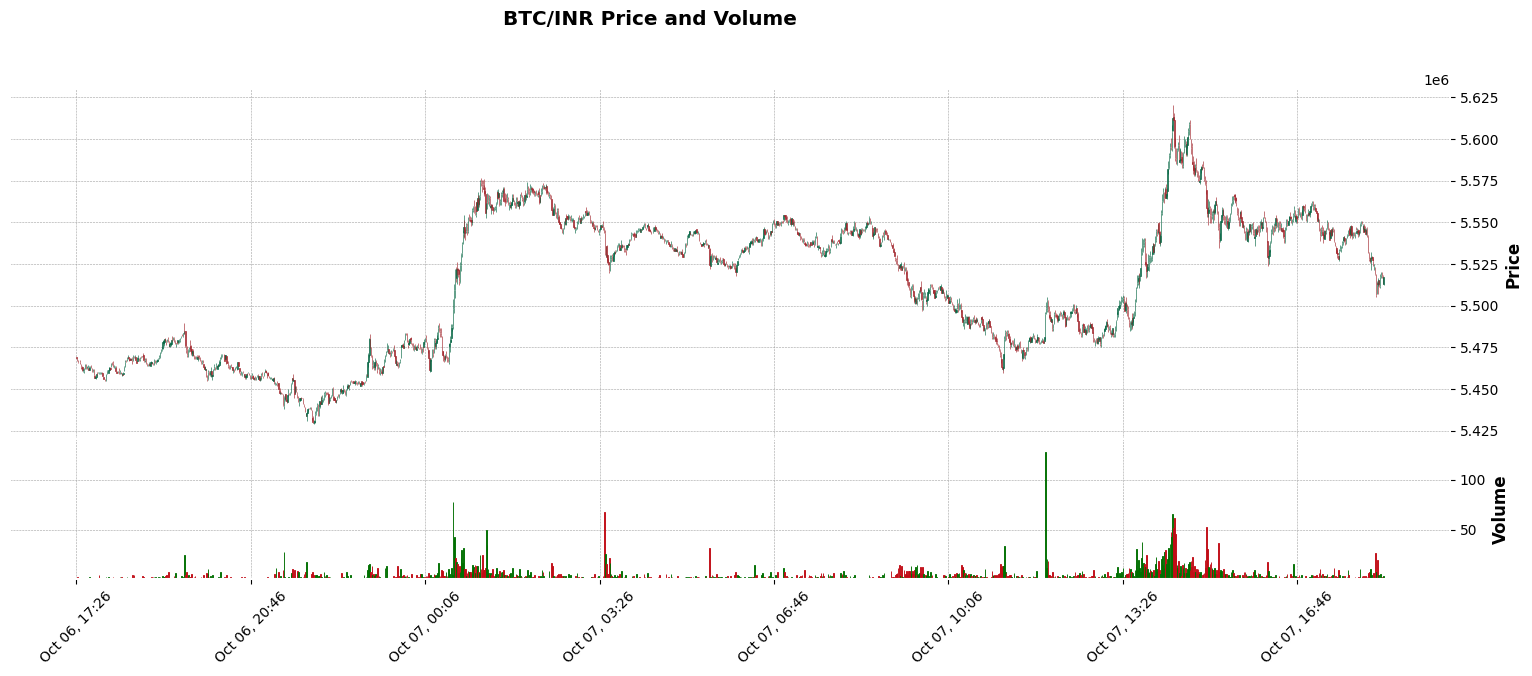

In [13]:
df.set_index('startTime', inplace=True)
mpf.plot(df, type='candle', style='charles', title='BTC/INR Price and Volume', volume=True, figsize=(20, 7))

#### There is an overall increase of price in Oct 06, 16:06 to Oct 07, 15:26. When the volume of BTC was high and also there was an upward trend in price.This indicates bullish market. High volume means a large number of people are buying and selling indicatig high interest and reliability in BTC. So, the sustainability and strength increase

Text(0, 0.5, 'BTC volume')

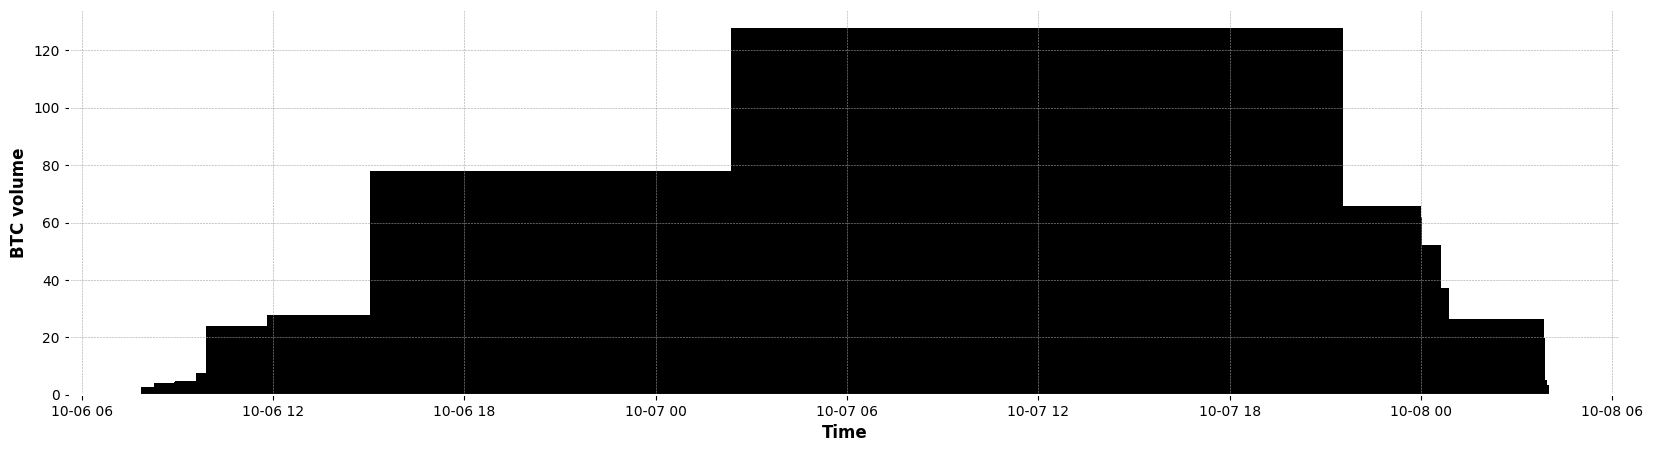

In [14]:
plt.figure(figsize=(20,5))
plt.bar(height=df["volume"], x = df.index, color="black")
plt.xlabel("Time")
plt.ylabel("BTC volume")

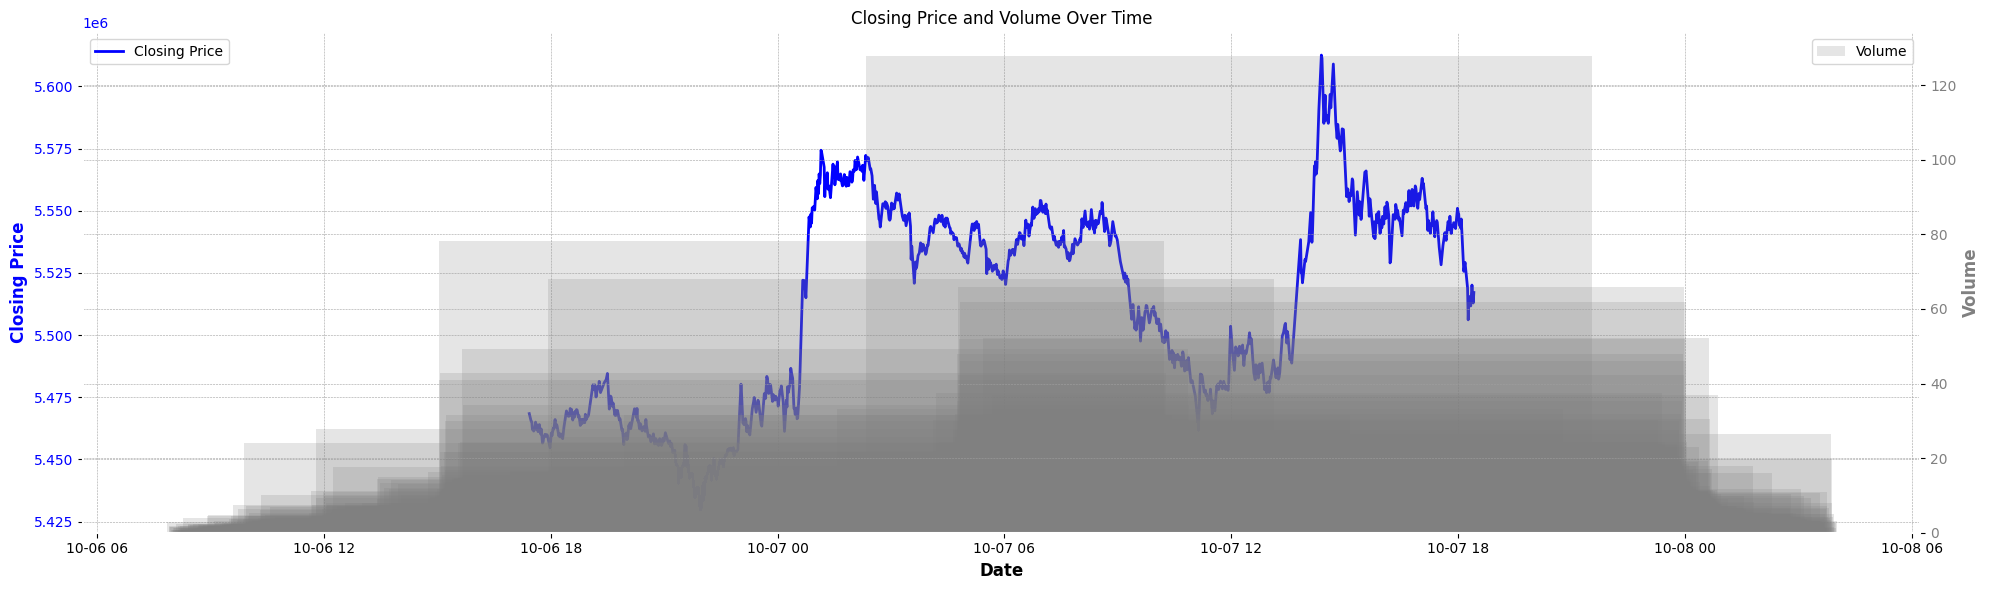

In [15]:
fig, ax1 = plt.subplots(figsize=(20, 6))
ax1.plot(df.index, df['close'], color='blue', label='Closing Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.bar(df.index, df['volume'], color='gray', alpha=0.2, label='Volume')
ax2.set_ylabel('Volume', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')
plt.title('Closing Price and Volume Over Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()  # Adjust layout to fit
plt.show()

small steps of price increment is seen, however, a reversal may be started gradually.

# Feature engineering --> creating key technical indicators

In [16]:
def calculate_rsi(data, period=15):
    '''
    Calculate Relative Strength Index for 15 interval period
    '''
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [17]:
df['RSI'] = calculate_rsi(df)
df['close_lag1'] = df['close'].shift(1)
df['stoch_k'] = (df['close'] - df['low'].rolling(window=14).min()) / (df['high'].rolling(window=14).max() - df['low'].rolling(window=14).min()) * 100
df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

#### The above features are added in the data frame and will be used as features

In [18]:
df = df.dropna() # droping the rows containing NaN values appeared due to rolling mean

In [19]:
# Feature selections

X = df[["RSI", "volume", "open", "high", "low", "close_lag1",  "stoch_k", "EMA12", "EMA26", "MACD", "MACD_Signal"]] # features
y = df[["close"]].shift(-1) # target column
y = y.dropna() # dropping the last NaN (due to shifting)
X = X.iloc[:-1] # dropiing the last row to make consistenst dimension

In [20]:
X.shape, y.shape # checking whether the split is correct or not in dimension

((1485, 11), (1485, 1))

In [21]:
train_size = int(len(X) * 0.7)  # using 70% of data for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# ML algorithm --> Single Decision Tree Regressor (Un-tuned)

In [22]:
decision_tree = DecisionTreeRegressor(random_state=0)
decision_tree.fit(X_train, y_train.values.ravel())
decision_tree_predictions = decision_tree.predict(X_test)

In [23]:
print("RMS error --> " + str(root_mean_squared_error(y_test, decision_tree_predictions)))
print("R^2 score --> " + str(r2_score(y_test, decision_tree_predictions)))

RMS error --> 10056.39069739956
R^2 score --> 0.9216014891652486


# ML algorithm --> Single Decision Tree Regressor (Tuned)

In [24]:
decision_tree = DecisionTreeRegressor(random_state=0)
tree_params = {
    'max_depth' : [5, 10, 20, 30, 50],
    'min_samples_leaf' : [1, 2, 4],
    'min_samples_split' : [2, 3, 5, 10]
}
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(decision_tree, tree_params, cv = tscv, refit='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train.values.ravel())
grid_search.best_params_


Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}

#### Single decision tree with tuned parameters

In [25]:
tuned_decision_tree = DecisionTreeRegressor(random_state=0, max_depth=20, min_samples_leaf=1, min_samples_split=3)
tuned_decision_tree.fit(X_train, y_train.values.ravel())
tuned_decision_tree_predictions = tuned_decision_tree.predict(X_test)

In [26]:
print("RMS error --> " + str(root_mean_squared_error(y_test, tuned_decision_tree_predictions)))
print("R^2 score --> " + str(r2_score(y_test, tuned_decision_tree_predictions)))

RMS error --> 10182.851129867837
R^2 score --> 0.9196173485809871


# ML algorithm --> Random Forest Regressor (tuned)

In [27]:
random_forest = RandomForestRegressor(random_state=0)
rf_params = {
    'n_estimators': [50, 100, 500],
    'max_depth': [10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.01, 0.1, 0.3]
}
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(random_forest, rf_params, cv = tscv, refit='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())
grid_search.best_params_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 50}

#### Random forest with tuned parameters

In [28]:
tuned_random_forest = RandomForestRegressor(random_state=0, max_depth=30, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=100)
tuned_random_forest.fit(X_train, y_train.values.ravel())
tuned_random_forest_prediction = tuned_random_forest.predict(X_test)

In [29]:
print("RMS error --> " + str(root_mean_squared_error(y_test, tuned_random_forest_prediction)))
print("R^2 score --> " + str(r2_score(y_test, tuned_random_forest_prediction)))

RMS error --> 8698.730300737676
R^2 score --> 0.9413409169130542


# ML algorithm --> XGBoost Regressor (tuned)

In [30]:
xgb = XGBRegressor(random_state=0)
xgb_params = {
    'n_estimators': [50, 100, 500],
    'max_depth': [10, 20, 30, 50],
    'min_child_weight': [1, 2, 4],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0]
}
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(xgb, xgb_params, cv=tscv, refit='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train.values.ravel())
grid_search.best_params_

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


{'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 2,
 'n_estimators': 500,
 'subsample': 1.0}

# Saving xgboost grid search result to save time (~ 22 mins)

In [34]:
import pickle
with open('xgb_grid_search.pkl', 'wb') as file:
    pickle.dump(grid_search, file)

with open('xgb_grid_search.pkl', 'rb') as file:
    grid_search = pickle.load(file)

grid_search.best_params_

{'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 2,
 'n_estimators': 500,
 'subsample': 1.0}

#### XGBoost with tuned parameters

In [35]:
tuned_xgb = XGBRegressor(random_state=0, n_estimators = 500 , max_depth = 50, min_child_weight = 4, learning_rate = 0.1, subsample = 0.6)
tuned_xgb.fit(X_train, y_train.values.ravel())
tuned_xgb_prediction = tuned_xgb.predict(X_test)

In [36]:
print("RMS error --> " + str(root_mean_squared_error(y_test, tuned_xgb_prediction)))
print("R^2 score --> " + str(r2_score(y_test, tuned_xgb_prediction)))

RMS error --> 8824.083914615438
R^2 score --> 0.9396381145134834


# Best forecasting model --> XGBoost Regressor

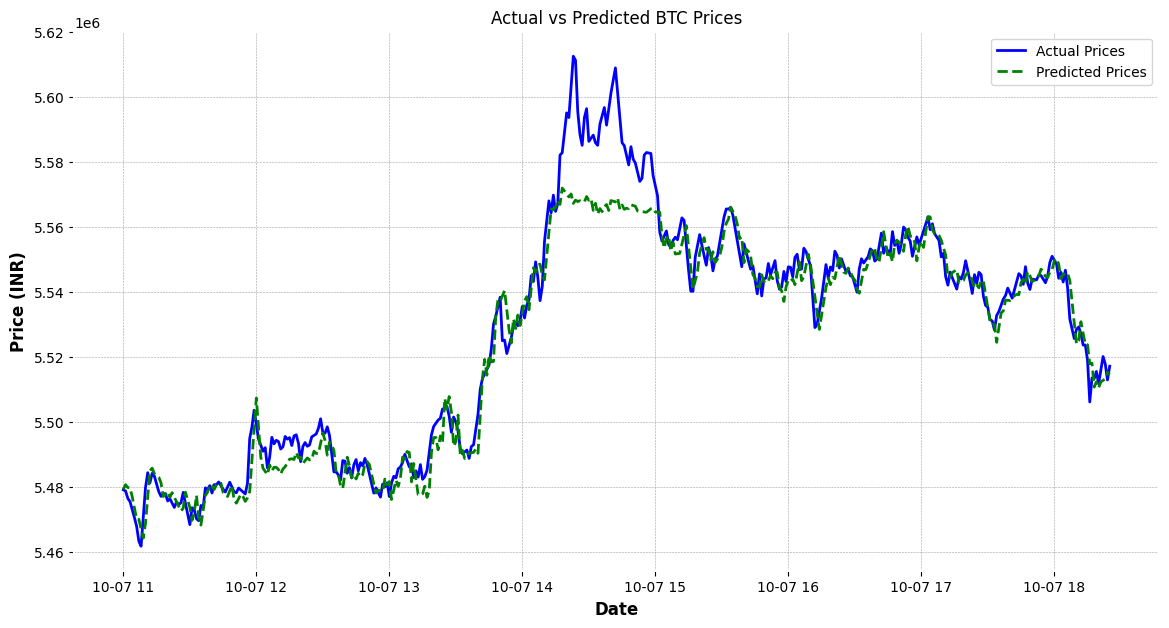

In [37]:
# Plotting actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test.values, label='Actual Prices', color='blue')
plt.plot(df.index[-len(y_test):], tuned_xgb_prediction, label='Predicted Prices', color='green', linestyle='--')
plt.title('Actual vs Predicted BTC Prices')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.show()

# Backtesting on prediction

In [48]:
# Trading strategy
initial_investment = 100000  # Starting with 100000
btc_holdings = 0  # No Bitcoin at the beginning
cash = initial_investment  # Start with all cash
portfolio_value = []  # Track the value of the portfolio over time
btc_prices = y_test.values  # Actual prices of BTC
predicted_prices = tuned_xgb_prediction  # Predicted prices, using most useful model

for i in range(len(btc_prices)):
    # Trading strategy loop
    if predicted_prices[i] > btc_prices[i]:  # Buy signal 
        if cash > 0:  # If we have cash, buy Bitcoin with all cash
            btc_holdings = cash / btc_prices[i]  # Buy as much Bitcoin as we can
            cash = 0  # All cash is invested in Bitcoin
    elif predicted_prices[i] < btc_prices[i]:  # Sell signal 
        if btc_holdings > 0:  # If we have Bitcoin, sell it all BTC
            cash = btc_holdings * btc_prices[i]  # Convert Bitcoin to cash
            btc_holdings = 0  # All Bitcoin is sold

    # value of Bitcoin holdings + cash is portfolio
    portfolio_value.append(btc_holdings * btc_prices[i] + cash)


In [53]:
portfolio_value = np.array(portfolio_value).flatten()

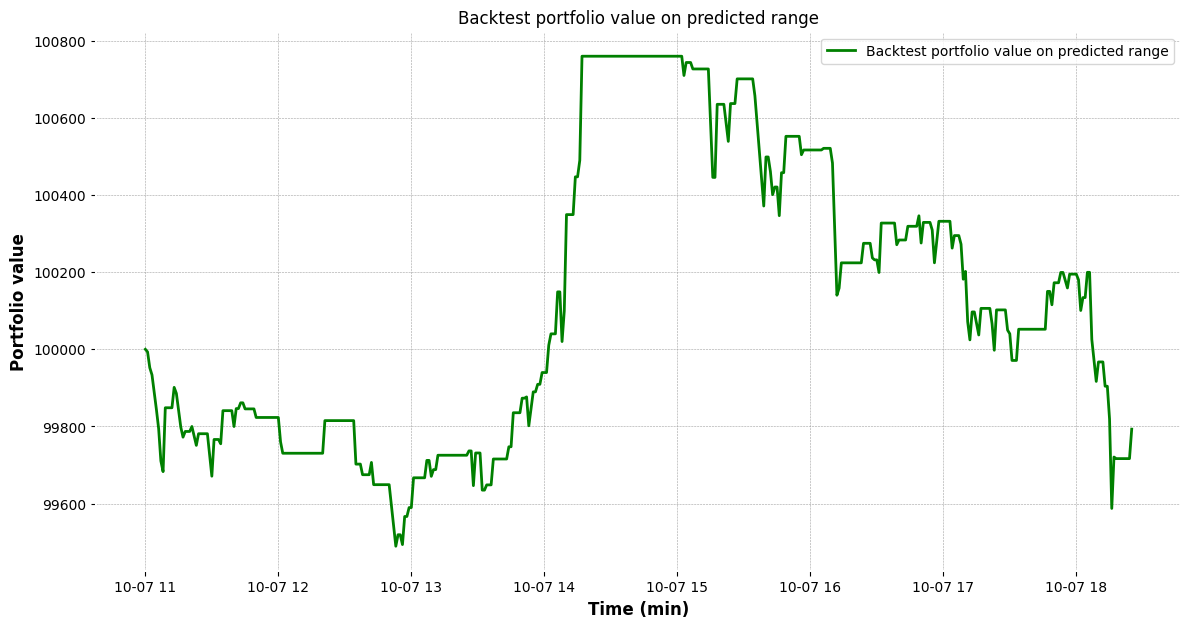

In [62]:
# Plot the portfolio value over time
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], portfolio_value, label='Backtest portfolio value on predicted range', color='green')
plt.title('Backtest portfolio value on predicted range')
plt.xlabel('Time (min)')
plt.ylabel('Portfolio value')
plt.legend()
plt.show()